# BUFN400: Homework 1: Introduction to Financial Analysis Using Pandas and WRDS CRSP Data

## By Albert S. (Pete) Kyle

### September 2025

**You should read this notebook carefully by studying each line of code to understand what it does computationally and why it is useful financially. There are homework questions at the end of this notebook. You should answer the homework questions by adding cells as necessary, then submit an HTML or PDF version of your homework to Canvas.**

**If you are not proficient in Python (especially the Pandas package), this homework will take a lot of time to complete properly.**

This notebook shows how to use the Python package Pandas to read, clean, and then examine datasets downloaded from WRDS.

In typical applications, the Python package Pandas is used for manipulating data. The Python package Numpy is used for numerical calculations, especially when numerical efficiency is important. 

When performing data analysis using Python, it is almost always inefficient (slow) to write interpreted Python loops of the form `for i in range(10**6): Do_something()`. Both Pandas and Numpy have efficient functions which make it mostly (but not always) unnecessary to write these inefficient Python loops.

Students should become familiar enough with Pandas to use the approach illustrated here on other datasets, regardless of size or complexity.

The example considered in this notebook is the  **CRSP Daily Stock file**.

**CRSP** is a popular, standard data source for financial information. It is widely used by academia, business, and government.  It has a reputation for excellent accuracy and comprehensive coverage. The University of Maryland subscribes to some of the CRSP data but not all of it. Financial data is often proprietary, and subscriptions are often expensive.

You should read each cell carefully, study each code cell carefully, and run all of the code cells on your own  computer. The functions used in the various code cells will be used throughout this course, including on the next homework and future homeworks! The Python (Pandas) usage illustrated here is typical of what you might do in a summer internship working for a financial firm.

**Please let me know if you see errors or things which are unclear, so that I can post a revised version.**

### Pandas DataFrames 

Pandas stores data as a dataframe (`pd.DataFrame`), a rectangular format which we can think of as columns of data, each of the same length. In principle, all of the data in one column must have the same `dtype` (e.g., `float64` or `int64` or string). Different columns may have different dtypes. In addition to the rectangle of data, a dataframe also has an index of names for each column and another index for each row. It is useful to think of a Panda's dataframe as a Python dictionary with additional structure enforcing consistency in lengths of columns, convenient indexing for both rows and columns, and numerous functions for data manipulation. This additional structure is precisely what is typically needed to play with financial datasets.

 A column of numbers in a Pandas dataframe can be thought of as a wrapper around a Numpy array. Getting started with Pandas can be confusing because the dtypes needed for numerical efficiency differ from the dtypes needed for data manipulation. This has led to changes in Pandas over the years. Two recent changes, which may be sources of confusion, are the following:

1. For data analysis, it is useful to have keep track of missing values and also make distinctions between values which are `None`, missing, or poorly defined. To handle this,  Pandas has recently introduced a "nullable integer" dtype, which can add functionality for missing data to Numpy's integer dtypes, which do not allow missing data. (Under the old approach, adding a missing value to a column of integers forced conversion of the column to a float type, which is often inconvenient and confusing.)

2. Pandas has traditionally had a clunky and inefficient way of handling columns of string data. Strings are stored as dtype `object`, which is a catchall for arbitrary or inconsistent dtypes. The `object` dtype handles strings flexibly but inefficiently. Pandas is in the process of replacing this inefficient `object` dtype with Pyarrow string dtypes, which are more efficient.

As a convenience, Pandas often uses string aliases to identify dtypes in a generic manner. The result is different and sometimes confusing names for almost identical dtypes (e.g., the string 'int' or 'integer', the Python type `int`, the Pandas dtype `pd.Int64`, and the Numpy dtype `np.int64`).

Pandas does have some limitations:

1. Pandas is inconvenient for storing matrices since a two-dimensional array does not easily fit into one column of data.

2. If numerically intensive analysis is needed, it is often a good idea to convert data from Pandas to Numpy. This may be efficient, since the data need not always be copied.

3. If numpy is not efficient enough, I recommend the Python package **Numba** for computations on the cpu (especially useful when inefficient Python loops would otherwise be needed),  the packages **Pytorch** or **Jax** for computations on a gpu, the Python package **Dask** (or **Ray** or **Modin** or **Vaex**) for multiprocessing of datasets too large to fit into memory, and the Python packages **Cupy** and **Cudf** in the **RAPIDS** family for Numpy-like and Pandas-like computations on a gpu. Some gpu-friendly packages, such as Jax and Cudf, only work under Linux. I use **Windows Subsystem for Linux** (**WSL**) for these packages, which works well.  Using a gpu, I can speed up my research on large datasets by factors like 20X relative to using 6-20 cpu cores on my laptop.



### Download data from the WRDS website

Go to the WRDS website https://wrds-www.wharton.upenn.edu/, log in using the credentials for BUFN400 (supplied separately), and find the CRSP daily stock files at

Home / Get Data / CRSP / Annual Update / Stock - Version 2 (CIZ) / Daily Stock File

which is here:

https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-version-2/daily-stock-file/

The term "Annual Update" refers to the fact that the University subscription is updated annually. Therefore, if you are downloading data in September 2025, the most recent data will be for December 31, 2024. Data for 2025 will become available well after the start of 2026.

There are five different tabs: Query Form, Variable Descriptions, Manuals and Overviews, Knowledge Base, Data Preview.

To download data, use the tab "Query Form". The other tabs containg important information which describes what the data mean.

Students in BUFN400 are required to download data using the "Query Form" web interface. Follow steps 1--4 as follows:

1. Choose the beginning date 1925-12-31 (the date when the data series begins) and the ending date 2024-12-31 (the most recent annual update).

2. Enter the following list of **ticker symbols** in the cell identified as "Search Name or Ticker": "GM IBM MSFT AAPL META GOOG TSLA INTC BAC BRK". These ticker symbols correspond to the current well-known companies we call General Motors, IBM, Microsoft, Apple, Meta (=Facebook), Google, Tesla, Intel, Bank of America, and Berkshire Hathaway. If you are particularly interested in some other companies, feel free to add them to the list as well.

3. Click on  the checked "All" box to move the names of all of the data series from the left side of the page ("Select", i.e., not selected yet) to the right side ("Selected", i.e., already selected for download).

4. Select the following options: "comma delimited text (*.csv)", "gzip (*.gz)", and "YYYY-MM-DD (e.g., 1984-07-25)". The `*.csv` format is used frequently in data analysis because it is easily read by humans, widely supported, and often compresses well. The `gzip` format is a convenient way to compress the data. The `YYYY-MM-DD` format is a convenient way to represent dates. Pandas handles many different data formats, but it handles `csv`, `gzip`, and `YYYY-MM-DD` especially efficiently and conveniently. (Feel free to experiment by checking different boxes to see what happens. Presumably, uncompressed data will be larger on disk and will probably download from the WRDS website  more slowly, but does it load from disk into memory faster? Considerations like this might be relevant when dealing with very large datasets.)

Then click "Submit Form". It may take WRDS several minutes to prepare your data, after which you may click a button to download it to your computer. (In my case, it took WRDS about five minutes to run the query, and the compressed dataset was about 7 MB.)

If you like, you might download the entire dataset, but make sure you have enough storage space first.  The entire dataset is likely 1000x or more larger than what is required for this assignment. If you would like to look at a smaller dataset with an exhaustive list of stocks, you might try downloading the monthly CRSP dataset.

WRDS gives the dataset a name consisting of random characters. I suggest renaming your dataset to something easy to identify.

**As we shall see, ticker symbols may not be the best way to identify companies. Nevertheless, it is instructive to use ticker symbols (at least once) to see what we learn about finance and to see what kinds of issues are raised by using ticker symbols.**


In [1]:
#import statements
import pandas as pd
import numpy as np
import scipy
#import scipy.sparse.linalg
import matplotlib
import matplotlib.pyplot as plt
import pyarrow

import sys
import io
import datetime
import timeit
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 100)

print(f"timestamp = {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('NumPy version ' + np.__version__)
print('SciPy version ' + scipy.__version__)
print('matplotlib version ' + matplotlib.__version__)
print('pyarrow version ' + pyarrow.__version__)

t_begin = timeit.default_timer()

timestamp = 2025-09-02 13:58:37
Python version 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:06:27) [MSC v.1942 64 bit (AMD64)]
Pandas version 2.2.3
NumPy version 1.26.4
SciPy version 1.15.1
matplotlib version 3.10.0
pyarrow version 19.0.0


### Use `pd.read_csv(...)` to load data

Many datasets can easily be read in one line with the function `pd.read_csv(...)`.  In other cases, reading in data properly takes some effort because the names and dtypes of columns are not accurately known in advance (in which case  data dictionaries are important!). Typical problems include the following:

1. Documentation for columns may be missing or incorrect.

2. The date formats may non-standard and different from one another.

3. The data formats may not be what is needed. For example, the data may be of type `float` when type `int` is needed.

4. It is not obvious whether certain columns should have dtype of `int`, `float`, `string`, `category`, or `datetime`.

These types of considerations are commonplace for all types of analysis - financial or otherwise. Make sure you understand what your data is saying before gleaning any inferences from it! 

A useful strategy is to try to read the data with a one-line version of `pd.read_csv(...)`, then do some preliminary data exploration to see whether further refinement is needed.

It is also typical to time specific code snippets to explore ways to improve code efficiency.

So let's try to read the data in one line and time it at the same time:

In [2]:
# Edit the following line to match the path in your computer:
dir_path = r"c:/users/askyl/downloads"
file_name = "CRSP-10-tickers-20250902.csv.gz"

# NB: I recommend os.path.join(...) over string addition. 
# os.path.join(...) remembers to place the '/' character correctly and works better across different operating systems. 
file_path = os.path.join(dir_path, file_name)
# file_path = dir_path + '/' + file_name

t0 = timeit.default_timer()
df = pd.read_csv(file_path)  # Read data in one simple line of code!
# df = pd.read_csv(file_path, parse_dates=True)  # Does not actually parse dates
# df = pd.read_csv(file_path, parse_dates=True, low_memory=False)  # Avoids DtypeWarning
dt = timeit.default_timer() - t0

print(f"Reading the data took {dt} seconds.")

Reading the data took 0.5674896000418812 seconds.


C:\Users\askyl\AppData\Local\Temp\ipykernel_4256\325084898.py:11: DtypeWarning: Columns (6,7,8,9,12,15,22,27,50,70,76,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)  # Read data in one simple line of code!



I received a warning like the warning:

"DtypeWarning: Columns (6,7,8,9,12,15,22,27,50,70,76,80) have mixed types. Specify dtype option on import or set low_memory=False."

This warning is typical. As we explore the data further, we will likely find out why we got the warning.




#### Basic information

Let's get some basic information about the dataframe `df`.

To do so, I will illustrate some commonly used Python and Pandas functions. You should become familiar with all of these functions in order to be proficient with Pandas.

In [3]:
print(f"Number of rows: {len(df)=}\n")
print(f"Number of columns: {len(df.columns)=}\n")
print(f"Names of columns: {df.columns=}\n")
print(f"Names of columns with warning: {df.columns[[6,7,8,9,12,15,22,27,50,70,76,80]]=}\n")

Number of rows: len(df)=112301

Number of columns: len(df.columns)=94

Names of columns: df.columns=Index(['PERMNO', 'SecInfoStartDt', 'SecInfoEndDt', 'SecurityBegDt', 'SecurityEndDt',
       'SecurityHdrFlg', 'HdrCUSIP', 'HdrCUSIP9', 'CUSIP', 'CUSIP9', 'PrimaryExch',
       'ConditionalType', 'ExchangeTier', 'TradingStatusFlg', 'SecurityNm', 'ShareClass',
       'USIncFlg', 'IssuerType', 'SecurityType', 'SecuritySubType', 'ShareType',
       'SecurityActiveFlg', 'DelActionType', 'DelStatusType', 'DelReasonType', 'DelPaymentType',
       'Ticker', 'TradingSymbol', 'PERMCO', 'SICCD', 'NAICS', 'ICBIndustry', 'NASDCompno',
       'NASDIssuno', 'IssuerNm', 'YYYYMMDD', 'DlyCalDt', 'DlyDelFlg', 'DlyPrc', 'DlyPrcFlg',
       'DlyCap', 'DlyCapFlg', 'DlyPrevPrc', 'DlyPrevPrcFlg', 'DlyPrevDt', 'DlyPrevCap',
       'DlyPrevCapFlg', 'DlyRet', 'DlyRetx', 'DlyRetI', 'DlyRetMissFlg', 'DlyRetDurFlg',
       'DlyOrdDivAmt', 'DlyNonOrdDivAmt', 'DlyFacPrc', 'DlyDistRetFlg', 'DlyVol', 'DlyClose',
       '

It is useful to display the first several rows of data and the last several rows of data.

In [4]:
df.head(5)

,PERMNO,SecInfoStartDt,SecInfoEndDt,SecurityBegDt,SecurityEndDt,SecurityHdrFlg,HdrCUSIP,HdrCUSIP9,CUSIP,CUSIP9,PrimaryExch,ConditionalType,ExchangeTier,TradingStatusFlg,SecurityNm,ShareClass,USIncFlg,IssuerType,SecurityType,SecuritySubType,ShareType,SecurityActiveFlg,DelActionType,DelStatusType,DelReasonType,DelPaymentType,Ticker,TradingSymbol,PERMCO,SICCD,NAICS,ICBIndustry,NASDCompno,NASDIssuno,IssuerNm,YYYYMMDD,DlyCalDt,DlyDelFlg,DlyPrc,DlyPrcFlg,DlyCap,DlyCapFlg,DlyPrevPrc,DlyPrevPrcFlg,DlyPrevDt,DlyPrevCap,DlyPrevCapFlg,DlyRet,DlyRetx,DlyRetI,DlyRetMissFlg,DlyRetDurFlg,DlyOrdDivAmt,DlyNonOrdDivAmt,DlyFacPrc,DlyDistRetFlg,DlyVol,DlyClose,DlyLow,DlyHigh,DlyBid,DlyAsk,DlyOpen,DlyNumTrd,DlyMMCnt,DlyPrcVol,ShrStartDt,ShrEndDt,ShrOut,ShrSource,ShrFacType,ShrAdrFlg,DisExDt,DisSeqNbr,DisOrdinaryFlg,DisType,DisFreqType,DisPaymentType,DisDetailType,DisTaxType,DisOrigCurType,DisDivAmt,DisFacPr,DisFacShr,DisDeclareDt,DisRecordDt,DisPayDt,DisPERMNO,DisPERMCO,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10107,1986-03-13,2004-06-09,1986-03-13,2024-12-31,N,59491810,594918104,59491810,594918104,Q,RW,NMS,A,MICROSOFT CORP; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,MSFT,MSFT,8048,7370,0,NOAVAIL,60008001,10539,MICROSOFT CORP,19860313,1986-03-13,N,28.00,TR,714532.00,BP,NaN,NS,NaN,NaN,MP,NaN,NaN,NaN,NS,MR,0.0,0.0,1.0,NO,3597701.0,28.00,25.5,29.25,27.75,28.00,NaN,3410.0,33.0,100735628.0,1986-03-13,1986-03-30,25519,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002131,0.002104,0.001268,0.001247,0.002795
1,10107,1986-03-13,2004-06-09,1986-03-13,2024-12-31,N,59491810,594918104,59491810,594918104,Q,RW,NMS,A,MICROSOFT CORP; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,MSFT,MSFT,8048,7370,0,NOAVAIL,60008001,10539,MICROSOFT CORP,19860314,1986-03-14,N,29.00,TR,740051.00,BP,28.00,TR,1986-03-13,714532.00,PB,0.035714,0.035714,0.0,NaN,D1,0.0,0.0,1.0,NO,1077151.0,29.00,28.0,29.50,29.00,29.25,NaN,1809.0,32.0,31237379.0,1986-03-13,1986-03-30,25519,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010278,0.010240,0.005065,0.004965,0.014409
2,10107,1986-03-13,2004-06-09,1986-03-13,2024-12-31,N,59491810,594918104,59491810,594918104,Q,RW,NMS,A,MICROSOFT CORP; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,MSFT,MSFT,8048,7370,0,NOAVAIL,60008001,10539,MICROSOFT CORP,19860317,1986-03-17,N,29.50,TR,752810.50,BP,29.00,TR,1986-03-14,740051.00,PB,0.017241,0.017241,0.0,NaN,D3,0.0,0.0,1.0,NO,465719.0,29.50,29.0,29.75,29.50,29.75,NaN,772.0,27.0,13738710.5,1986-03-13,1986-03-30,25519,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007085,-0.007120,-0.004117,-0.004179,-0.007948
3,10107,1986-03-13,2004-06-09,1986-03-13,2024-12-31,N,59491810,594918104,59491810,594918104,Q,RW,NMS,A,MICROSOFT CORP; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,MSFT,MSFT,8048,7370,0,NOAVAIL,60008001,10539,MICROSOFT CORP,19860318,1986-03-18,N,28.75,TR,733671.25,BP,29.50,TR,1986-03-17,752810.50,PB,-0.025424,-0.025424,0.0,NaN,D1,0.0,0.0,1.0,NO,232056.0,28.75,28.5,29.75,28.75,29.00,NaN,484.0,25.0,6671610.0,1986-03-13,1986-03-30,25519,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004968,0.004894,0.003313,0.003278,0.004730
4,10107,1986-03-13,2004-06-09,1986-03-13,2024-12-31,N,59491810,594918104,59491810,594918104,Q,RW,NMS,A,MICROSOFT CORP; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,MSFT,MSFT,8048,7370,0,NOAVAIL,60008001,10539,MICROSOFT CORP,19860319,1986-03-19,N,28.25,TR,720911.75,BP,28.75,TR,1986-03-18,733671.25,PB,-0.017391,-0.017391,0.0,NaN,D1,0.0,0.0,1.0,NO,168024.0,28.25,28.0,29.00,28.00,28.25,NaN,377.0,24.0,4746678.0,1986-03-13,1986-03-30,25519,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001350,-0.001372,0.000262,0.000241,-0.000763


In [5]:
df.tail(4)

,PERMNO,SecInfoStartDt,SecInfoEndDt,SecurityBegDt,SecurityEndDt,SecurityHdrFlg,HdrCUSIP,HdrCUSIP9,CUSIP,CUSIP9,PrimaryExch,ConditionalType,ExchangeTier,TradingStatusFlg,SecurityNm,ShareClass,USIncFlg,IssuerType,SecurityType,SecuritySubType,ShareType,SecurityActiveFlg,DelActionType,DelStatusType,DelReasonType,DelPaymentType,Ticker,TradingSymbol,PERMCO,SICCD,NAICS,ICBIndustry,NASDCompno,NASDIssuno,IssuerNm,YYYYMMDD,DlyCalDt,DlyDelFlg,DlyPrc,DlyPrcFlg,DlyCap,DlyCapFlg,DlyPrevPrc,DlyPrevPrcFlg,DlyPrevDt,DlyPrevCap,DlyPrevCapFlg,DlyRet,DlyRetx,DlyRetI,DlyRetMissFlg,DlyRetDurFlg,DlyOrdDivAmt,DlyNonOrdDivAmt,DlyFacPrc,DlyDistRetFlg,DlyVol,DlyClose,DlyLow,DlyHigh,DlyBid,DlyAsk,DlyOpen,DlyNumTrd,DlyMMCnt,DlyPrcVol,ShrStartDt,ShrEndDt,ShrOut,ShrSource,ShrFacType,ShrAdrFlg,DisExDt,DisSeqNbr,DisOrdinaryFlg,DisType,DisFreqType,DisPaymentType,DisDetailType,DisTaxType,DisOrigCurType,DisDivAmt,DisFacPr,DisFacShr,DisDeclareDt,DisRecordDt,DisPayDt,DisPERMNO,DisPERMCO,vwretd,vwretx,ewretd,ewretx,sprtrn
112297,93436,2023-10-01,2024-12-31,2010-06-29,2024-12-31,Y,88160R10,88160R101,88160R10,88160R101,Q,RW,Q,A,TESLA INC; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,TSLA,TSLA,53453,9999,336110,NOAVAIL,60069832,66252,TESLA INC,20241226,2024-12-26,N,454.13,TR,1.457785e+09,BP,462.28,TR,2024-12-24,1.483947e+09,PB,-0.017630,-0.017630,0.0,NaN,D2,0.0,0.0,1.0,NO,76392273.0,454.13,451.02,465.3299,453.95,454.01,465.16,1257374.0,56.0,3.469202e+10,2024-10-18,2024-12-31,3210060,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000346,0.000282,0.012231,0.012038,-0.000406
112298,93436,2023-10-01,2024-12-31,2010-06-29,2024-12-31,Y,88160R10,88160R101,88160R10,88160R101,Q,RW,Q,A,TESLA INC; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,TSLA,TSLA,53453,9999,336110,NOAVAIL,60069832,66252,TESLA INC,20241227,2024-12-27,N,431.66,TR,1.385654e+09,BP,454.13,TR,2024-12-26,1.457785e+09,PB,-0.049479,-0.049479,0.0,NaN,D1,0.0,0.0,1.0,NO,82370345.0,431.66,426.50,450.0000,431.56,431.78,449.52,1351514.0,56.0,3.555598e+10,2024-10-18,2024-12-31,3210060,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010692,-0.010775,-0.004451,-0.004754,-0.011056
112299,93436,2023-10-01,2024-12-31,2010-06-29,2024-12-31,Y,88160R10,88160R101,88160R10,88160R101,Q,RW,Q,A,TESLA INC; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,TSLA,TSLA,53453,9999,336110,NOAVAIL,60069832,66252,TESLA INC,20241230,2024-12-30,N,417.41,TR,1.339911e+09,BP,431.66,TR,2024-12-27,1.385654e+09,PB,-0.033012,-0.033012,0.0,NaN,D3,0.0,0.0,1.0,NO,64705452.0,417.41,415.75,427.0000,417.17,417.36,419.40,1185995.0,56.0,2.700870e+10,2024-10-18,2024-12-31,3210060,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009878,-0.009900,-0.000715,-0.001173,-0.010702
112300,93436,2023-10-01,2024-12-31,2010-06-29,2024-12-31,Y,88160R10,88160R101,88160R10,88160R101,Q,RW,Q,A,TESLA INC; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,TSLA,TSLA,53453,9999,336110,NOAVAIL,60069832,66252,TESLA INC,20241231,2024-12-31,N,403.84,TR,1.296351e+09,BP,417.41,TR,2024-12-30,1.339911e+09,PB,-0.032510,-0.032510,0.0,NaN,D1,0.0,0.0,1.0,NO,76455213.0,403.84,402.54,427.9300,403.63,403.64,423.79,1213858.0,56.0,3.087567e+10,2024-10-18,2024-12-31,3210060,OBS,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003392,-0.003541,-0.000125,-0.000491,-0.004285


It is also useful to know the dtypes for the columns:

In [6]:
df.dtypes

PERMNO                 int64
SecInfoStartDt        object
SecInfoEndDt          object
SecurityBegDt         object
SecurityEndDt         object
SecurityHdrFlg        object
HdrCUSIP              object
HdrCUSIP9             object
CUSIP                 object
CUSIP9                object
PrimaryExch           object
ConditionalType       object
ExchangeTier          object
TradingStatusFlg      object
SecurityNm            object
ShareClass            object
USIncFlg              object
IssuerType            object
SecurityType          object
SecuritySubType       object
ShareType             object
SecurityActiveFlg     object
DelActionType         object
DelStatusType         object
DelReasonType         object
DelPaymentType        object
Ticker                object
TradingSymbol         object
PERMCO                 int64
SICCD                  int64
NAICS                  int64
ICBIndustry           object
NASDCompno             int64
NASDIssuno             int64
IssuerNm      

There are other simple functions for describing dataframes:

In [7]:
df.describe()

,PERMNO,PERMCO,SICCD,NAICS,NASDCompno,NASDIssuno,YYYYMMDD,DlyPrc,DlyCap,DlyPrevPrc,DlyPrevCap,DlyRet,DlyRetx,DlyRetI,DlyOrdDivAmt,DlyNonOrdDivAmt,DlyFacPrc,DlyVol,DlyClose,DlyLow,DlyHigh,DlyBid,DlyAsk,DlyOpen,DlyNumTrd,DlyMMCnt,DlyPrcVol,ShrOut,DisSeqNbr,DisDivAmt,DisFacPr,DisFacShr,DisPERMNO,DisPERMCO,vwretd,vwretx,ewretd,ewretx,sprtrn
count,112301.000000,112301.000000,112301.000000,112301.000000,1.123010e+05,112301.000000,1.123010e+05,112291.000000,1.122910e+05,112278.000000,1.122780e+05,112278.000000,112278.000000,112278.000000,112301.000000,112301.0,112301.000000,1.093010e+05,108987.000000,108927.000000,108925.000000,85134.000000,85134.000000,75811.000000,4.288500e+04,43505.000000,1.093010e+05,1.123010e+05,1123.000000,1073.000000,1123.000000,1123.000000,1123.000000,1123.000000,112301.000000,112301.000000,112301.000000,112301.000000,112299.000000
mean,35971.682550,14274.819485,5098.978887,196165.737500,3.926567e+07,7246.616352,1.999763e+07,12577.661147,1.712740e+08,12573.065434,1.711869e+08,0.000780,0.000701,0.000079,0.005547,0.0,1.001028,1.493936e+07,12955.862742,12867.171206,13056.111170,16403.622498,16430.982684,18439.648569,1.221614e+05,57.498035,1.280938e+09,1.778131e+06,1.021371,0.576599,0.102615,0.102725,293.609083,139.681211,0.000460,0.000359,0.000701,0.000620,0.000379
std,28074.116923,15991.390437,1815.629590,225512.566073,2.854065e+07,17612.655878,1.629506e+05,60528.177538,3.832610e+08,60498.669547,3.829880e+08,0.024572,0.024593,0.001085,0.080624,0.0,0.159631,3.531830e+07,61399.086437,60963.257261,61876.405133,69001.149288,69097.211370,72983.230441,2.222674e+05,21.939477,3.390417e+09,3.037217e+06,0.150718,0.702948,1.593749,1.593787,4662.575161,2309.576859,0.010588,0.010588,0.009288,0.009290,0.010901
min,10107.000000,7.000000,2070.000000,0.000000,0.000000e+00,0.000000,1.962070e+07,0.200000,1.227200e+03,0.200000,1.227200e+03,-0.518692,-0.518692,0.000000,0.000000,0.0,1.000000,0.000000e+00,0.200000,0.180000,0.250000,0.230000,0.250000,0.220000,0.000000e+00,0.000000,0.000000e+00,1.000000e+02,1.000000,0.005000,0.000000,0.000000,0.000000,0.000000,-0.171345,-0.171419,-0.107631,-0.107768,-0.204669
25%,12490.000000,540.000000,3573.000000,0.000000,0.000000e+00,0.000000,1.987123e+07,32.125000,1.051004e+07,32.125000,1.050734e+07,-0.009344,-0.009453,0.000000,0.000000,0.0,1.000000,5.310000e+04,32.405000,32.000000,32.880000,34.180000,34.250000,35.520000,1.983000e+03,47.000000,1.947730e+07,5.513600e+04,1.000000,0.180000,0.000000,0.000000,0.000000,0.000000,-0.004052,-0.004177,-0.003083,-0.003181,-0.004428
50%,17778.000000,8048.000000,3711.000000,0.000000,6.000054e+07,8.000000,2.001100e+07,68.875000,5.153230e+07,68.875000,5.153030e+07,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,2.322176e+06,71.125000,70.360000,72.000000,74.380000,74.640000,89.000000,4.649000e+04,59.000000,2.048181e+08,3.489520e+05,1.000000,0.365000,0.000000,0.000000,0.000000,0.000000,0.000728,0.000623,0.001308,0.001215,0.000532
75%,59328.000000,20990.000000,6331.000000,336111.000000,6.000315e+07,4005.000000,2.014023e+07,203.490000,1.708209e+08,203.407500,1.708041e+08,0.010363,0.010309,0.000000,0.000000,0.0,1.000000,1.391593e+07,213.315000,211.250000,215.900000,230.125000,230.180000,307.750000,1.411180e+05,71.000000,1.191780e+09,1.496314e+06,1.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.005441,0.005335,0.005050,0.004959,0.005554
max,93436.000000,56315.000000,9999.000000,541512.000000,6.007642e+07,74070.000000,2.024123e+07,724040.000000,3.915300e+09,724040.000000,3.915300e+09,0.625000,0.625000,0.102769,3.440000,0.0,50.000000,1.226791e+09,724040.000000,723050.000000,741971.400000,724160.000000,725500.000000,730090.800000,3.235250e+06,111.000000,1.551833e+11,1.710254e+07,3.000000,13.716500,49.000000,49.000000,86591.000000,58784.000000,0.114918,0.114856,0.107422,0.107335,0.115800


### What do the data mean?

There are two ways to determine what these 94 different columns mean:

1. Read the documentation or data description in the tabs "Variable Descriptions", "Manuals and Overviews", and "Knowledge Base" on the page the data was downloaded from.

2. Experiment with the data itself to try to figure out what the data mean.

In practice, documentation is sometimes missing, incomplete, or inaccurate. Sometimes, the data has errors. Therefore it is a good idea to combine both approaches.

An important issue concerns how to identify the companies we are interested in.

CRSP uses `PERMNO` and `PERMCO` to identify companies and securities. `PERMNO` is a permanent identifier for a security, and `PERMCO` is a permanent identifier for the issuing company. The identifiers are assigned by CRSP. Both `PERMNO` and `PERMCO` are needed because one company can issue multiple securities, such as common stock and preferred stock or different classes of common stock.  

Let us explore the columns labeled `PERMNO` and `PERMCO`. 

The WRDS website has information about `PERMNO` AND `PERMCO`. Since CRSP data is widely used in business, government, and academia, it is also easy to ask specific questions using google. To get background information, try googling:  "What is a CRSP PERMNO?" "What is the difference between CRSP PERMCO and PERMNO?"

Based on the name of the column, reading the documentation, or looking at the output in the previous cell,  we can guess that `SecurityNm` and `IssuerNm` identify the name of the security and the name of the issuer, respectively, as human-readable strings. So let's count the number of rows (number of trading days) corresponding to different combinations of `PERMCO`, `PERMNO`, `SecurityNm`, and `IssuerNm`.

We can see from `df.head()` that `Ticker` and `TradingSymbol` also identify the company using a ticker symbol.

We can also see that that `SecurityEndDt`, typically '2024-12-31', identifies the last date for information about the security, corresponding to the last trading day in 2024. The companies we are interested in should have a `SecurityEndDt` corresponding to the end of 2024. Companies which not longer exist should have an earlier value for `SecurityEndDt`.



### Pandas dtype `object` for string data, using `pd.to_datetime` to convert string to date

The Pandas dtype `object` often represents **string** data. Note that 'YYYYMMSS', 'PERMCO' and 'PERMNO' are an of type `int64`, not string or special date format. `SecurityEndDt` was read as type `object` (which typically, but not always, indicates string data).

You can verify from the first few lines of data that column names ending in 'Dt' are dates. The Pandas function `pd.read_csv(...)` did not convert these columns to a data format but instead left them as strings. Pandas has special dtypes for representing dates. 

Use the function `pd.to_datetime(...)` to convert date columns from dtype object (string) to `datetime`. 

Noticing that date columns' names end with 'Dt', we can try the following:

In [8]:
for vn in df.columns:
    if vn[-2:] == 'Dt':
        try:
            df[vn] = pd.to_datetime(df[vn])
            print(f"{vn}: success, converted to type {df[vn].dtype}")
        except:
            print(f"{vn}: fail")  

SecInfoStartDt: success, converted to type datetime64[ns]
SecInfoEndDt: success, converted to type datetime64[ns]
SecurityBegDt: success, converted to type datetime64[ns]
SecurityEndDt: success, converted to type datetime64[ns]
DlyCalDt: success, converted to type datetime64[ns]
DlyPrevDt: success, converted to type datetime64[ns]
ShrStartDt: success, converted to type datetime64[ns]
ShrEndDt: success, converted to type datetime64[ns]
DisExDt: success, converted to type datetime64[ns]
DisDeclareDt: success, converted to type datetime64[ns]
DisRecordDt: success, converted to type datetime64[ns]
DisPayDt: success, converted to type datetime64[ns]


The columns with dtype object are typically strings. For processing large amounts of data, the Pyarrow string dtype is more efficient than the Pandas `object` dtype. So let's try to convert the columns which are dtype `object` to Pyarrow strings:

In [9]:
for vn in df.columns:
    if df[vn].dtype == 'object':
        try:
            df[vn] = df[vn].astype('string')
            # df[vn] = df[vn].astype('string[pyarrow]')
            print(f"{vn} converted to {df[vn].dtype}.")
        except:    
            print(f"Failed to convert {vn} to pyarrow string.")


SecurityHdrFlg converted to string.
HdrCUSIP converted to string.
HdrCUSIP9 converted to string.
CUSIP converted to string.
CUSIP9 converted to string.
PrimaryExch converted to string.
ConditionalType converted to string.
ExchangeTier converted to string.
TradingStatusFlg converted to string.
SecurityNm converted to string.
ShareClass converted to string.
USIncFlg converted to string.
IssuerType converted to string.
SecurityType converted to string.
SecuritySubType converted to string.
ShareType converted to string.
SecurityActiveFlg converted to string.
DelActionType converted to string.
DelStatusType converted to string.
DelReasonType converted to string.
DelPaymentType converted to string.
Ticker converted to string.
TradingSymbol converted to string.
ICBIndustry converted to string.
IssuerNm converted to string.
DlyDelFlg converted to string.
DlyPrcFlg converted to string.
DlyCapFlg converted to string.
DlyPrevPrcFlg converted to string.
DlyPrevCapFlg converted to string.
DlyRetMis

#### `parquet` files

Converting csv files into pandas dataframes, converting strings to dates, and converting dtype object to Pyarrow strings are all potentially slow calculations, which can present a bottleneck when working with large datasets.

It is therefore typical to store a dataframe in a more convenient format.  I like the **parquet** format, which allows fast reading of datasets into memory and also has efficient column-by-column compression, which works especially well for columns with repeated data.

In [10]:
parquet_file_path = os.path.join(dir_path, "crsp_hw1.parquet")
df.to_parquet(parquet_file_path, engine='pyarrow')

Reading a `parquet` file is much faster than reading a CSV file, then converting strings to dates, and doin other conversions:

In [11]:
df_new = pd.read_parquet(parquet_file_path, engine='pyarrow', dtype_backend='pyarrow')
# df_new = pd.read_parquet(parquet_file_path)

In [12]:
df_new.dtypes

PERMNO                       int64[pyarrow]
SecInfoStartDt       timestamp[ns][pyarrow]
SecInfoEndDt         timestamp[ns][pyarrow]
SecurityBegDt        timestamp[ns][pyarrow]
SecurityEndDt        timestamp[ns][pyarrow]
SecurityHdrFlg              string[pyarrow]
HdrCUSIP                    string[pyarrow]
HdrCUSIP9                   string[pyarrow]
CUSIP                       string[pyarrow]
CUSIP9                      string[pyarrow]
PrimaryExch                 string[pyarrow]
ConditionalType             string[pyarrow]
ExchangeTier                string[pyarrow]
TradingStatusFlg            string[pyarrow]
SecurityNm                  string[pyarrow]
ShareClass                  string[pyarrow]
USIncFlg                    string[pyarrow]
IssuerType                  string[pyarrow]
SecurityType                string[pyarrow]
SecuritySubType             string[pyarrow]
ShareType                   string[pyarrow]
SecurityActiveFlg           string[pyarrow]
DelActionType               stri

#### Exploring data

We can count the number of rows with specific values:

In [13]:
df['IssuerNm'].value_counts()

IssuerNm
BERKSHIRE HATHAWAY INC DEL          16302
INTERNATIONAL BUSINESS MACHS COR    15733
INTEL CORP                          13124
GENERAL MOTORS CORP                 11825
MICROSOFT CORP                       9780
APPLE COMPUTER INC                   6581
BANK OF AMERICA CORP                 6461
APPLE INC                            4524
BANKAMERICA CORP                     4246
GENERAL MOTORS CO                    3552
BROCKWAY GLASS INC                   2995
GOOGLE INC                           2801
ALPHABET INC                         2326
METATEC CORP                         1998
TESLA INC                            1991
TESLA MOTORS INC                     1661
BACHE GROUP INC                      1610
BROCKWAY INC NY                      1476
BRACH E J & SONS INC                  956
METATEC INTERNATIONAL INC             749
BACHE & CO INC                        674
META PLATFORMS INC                    644
LISTED FUNDS TRUST                    148
BANKAMERICA CORP NEW     

We see the readable names of all ten of the companies we expect (e.g., General Motors, Google, Apple) and also some names we might not expect (Bache, Brockway Glass, Metatec).

What is going on here?

We can get a better idea by chaining functions together, as follows:

In [14]:
vns = ['PERMCO', 'PERMNO', 'Ticker', 'IssuerNm', 'SecurityNm', 'SecurityBegDt', 'SecurityEndDt',  'ShareClass']

df[vns].value_counts(dropna=False).reset_index(drop=False).sort_values(['Ticker', 'SecurityBegDt'])


,PERMCO,PERMNO,Ticker,IssuerNm,SecurityNm,SecurityBegDt,SecurityEndDt,ShareClass,count
6,7,14593,AAPL,APPLE COMPUTER INC,APPLE COMPUTER INC; COM NONE; CONS,1980-12-12,2024-12-31,<NA>,6581
8,7,14593,AAPL,APPLE INC,APPLE INC; COM NONE; CONS,1980-12-12,2024-12-31,<NA>,4524
18,25401,54893,BAC,BACHE GROUP INC,BACHE GROUP INC; COM NONE; CONS,1972-05-31,1981-06-11,<NA>,1610
22,25401,54893,BAC,BACHE & CO INC,BACHE & CO INC; COM NONE; CONS,1972-05-31,1981-06-11,<NA>,674
7,3151,59408,BAC,BANK OF AMERICA CORP,BANK OF AMERICA CORP; COM NONE; CONS,1972-12-14,2024-12-31,<NA>,6461
9,437,58827,BAC,BANKAMERICA CORP,BANKAMERICA CORP; COM NONE; CONS,1972-12-14,1998-09-30,<NA>,4246
26,3151,59408,BAC,BANKAMERICA CORP NEW,BANKAMERICA CORP NEW; COM NONE; CONS,1972-12-14,2024-12-31,<NA>,144
20,24314,38404,BRK,BRACH E J & SONS INC,BRACH E J & SONS INC; COM NONE; CONS,1962-08-06,1966-05-20,<NA>,956
11,25142,50737,BRK,BROCKWAY GLASS INC,BROCKWAY GLASS INC; COM NONE; CONS,1970-06-19,1988-02-29,<NA>,2995
19,25142,50737,BRK,BROCKWAY INC NY,BROCKWAY INC NY; COM NONE; CONS,1970-06-19,1988-02-29,<NA>,1476


Notice the following about the above Pandas functions:

1. I considered only a subset of columns using `vns = ['PERMCO', 'PERMNO', 'Ticker', 'IssuerNm', 'SecurityNm', 'SecurityBegDt', 'SecurityEndDt',  'ShareClass']`. If I had not defined this list of column names as a separate variable I would have needed double square brackets to write `df[['PERMCO', 'PERMNO', 'Ticker', 'IssuerNm', 'SecurityNm', 'SecurityBegDt', 'SecurityEndDt',  'ShareClass']].value_counts()`. Forgetting the double square brackets is a common source of errors if you are not used to Pandas yet.

2. The option `dropna=False` tells Pandas to count rows with missing data instead of ignoring such rows.

3. Pandas associates both a row index and a column index with the "rectangle" of data which defines the dataframe. In the output of the function `value_counts`, the list of variable names `vns` becomes a row index, which is separate from the data.  Often, we want the index to be part of the data.  The function `reset_index(drop=False)` tells Pandas to drop the index but keep the data in the index as part of the dataframe.  In other words, the columns defining the index become columns of data instead of names for the rows. A dataframe always has an index. If no other index is defined, the index will be integers defining an ordering to the data.

4. The function `sort_values(['Ticker', 'BegDt'])` sorts the values by the 'Ticker' column first, then by the 'BegDt' column in case of ties. 

5. It is often convenient to chain Pandas functions together, like I have done above with `df[vns].value_counts(dropna=False).reset_index(drop=False).sort_values('Ticker')`. This works because the output of each function is a dataframe to which the next function can be applied.

#### Usage of `groupby`

The `groupby` function is a powerfual way to examine data. Read the Pandas documentation for details.

The next cell illustrates how I like to use `groupby`. This is a poorly documented but flexible approach which is a variation on "Named Aggregation", discussed in the Pandas documentation here:

https://pandas.pydata.org/docs/user_guide/groupby.html#groupby-aggregate-named

The dataframe is grouped by the variables in the list of column names `vns` to create a new output dataframe in which each row is a unique combination of values associated with each of the column names in `vns`.  The extra variable '[YYYYMMDD]' is a list of the names of columns to which functions are applied (in this case only one column, 'YYYYMMDD').

In the dictionary `aggregations`, the key to the first entry 'YYYYMMDD_min' is my name for a new column;. the corresponding dictionary value `('YYYYMMDD', 'min')` is a tuple  which specifies an existing column, 'YYYYMMDD', to which a specific function, 'min', is applied.

The function `sort_values(['Ticker', 'YYYYMMDD_min'])` sorts the rows in such a way that the resulting dataframe tells a history of the usage of all ten ticker symbols.

In [15]:
# vns = ['Ticker', 'TradingSymbol',  'ShareClass', 'PERMCO', 'PERMNO', 'IssuerNm', 'SecurityNm', 'PrimaryExch']
vns = ['Ticker',  'ShareClass', 'PERMCO', 'PERMNO', 'IssuerNm', 'SecurityNm', 'PrimaryExch']

aggregations = {'YYYYMMDD_min' : ('YYYYMMDD', 'min'), 
                'YYYYMMDD_max' : ('YYYYMMDD', 'max'),
                'num_days' : ('YYYYMMDD', 'count')}

dfgb = df[vns + ['YYYYMMDD']].groupby(vns, dropna=False).agg(**aggregations).reset_index(drop=False).sort_values(['Ticker', 'YYYYMMDD_min', 'ShareClass'])

display(dfgb)

,Ticker,ShareClass,PERMCO,PERMNO,IssuerNm,SecurityNm,PrimaryExch,YYYYMMDD_min,YYYYMMDD_max,num_days
0,AAPL,<NA>,7,14593,APPLE COMPUTER INC,APPLE COMPUTER INC; COM NONE; CONS,Q,19801212,20070110,6581
1,AAPL,<NA>,7,14593,APPLE INC,APPLE INC; COM NONE; CONS,Q,20070111,20241231,4524
5,BAC,<NA>,25401,54893,BACHE & CO INC,BACHE & CO INC; COM NONE; CONS,N,19720531,19750131,674
6,BAC,<NA>,25401,54893,BACHE GROUP INC,BACHE GROUP INC; COM NONE; CONS,N,19750203,19810611,1610
2,BAC,<NA>,437,58827,BANKAMERICA CORP,BANKAMERICA CORP; COM NONE; CONS,N,19811215,19980930,4246
4,BAC,<NA>,3151,59408,BANKAMERICA CORP NEW,BANKAMERICA CORP NEW; COM NONE; CONS,N,19981001,19990428,144
3,BAC,<NA>,3151,59408,BANK OF AMERICA CORP,BANK OF AMERICA CORP; COM NONE; CONS,N,19990429,20241231,6461
10,BRK,<NA>,24314,38404,BRACH E J & SONS INC,BRACH E J & SONS INC; COM NONE; CONS,N,19620806,19660520,956
11,BRK,<NA>,25142,50737,BROCKWAY GLASS INC,BROCKWAY GLASS INC; COM NONE; CONS,N,19700619,19820428,2995
12,BRK,<NA>,25142,50737,BROCKWAY INC NY,BROCKWAY INC NY; COM NONE; CONS,N,19820429,19880229,1476


### What we learn financially

The dataframe in the above cell tells a history of the ten ticker symbols.  This history illustrates some interesting points:

1. Companies change their name from time to time. For example, Apple changed from "Apple Computer Inc" to "Apple Inc" on 2007-01-11.

2. Some companies issue different classes of common stock. For example, Berkshire Hathaway has two classes, A and B. The ticker symbol BRK applies to the company as a whole. CRSP assigns two different PERMNO values for the two different classes of common stock.

3. Different companies use the same ticker symbols, but they use them at different times. For example, the ticker symbol 'BAC' was used by Bache & Co (an investment investment bank) in the 1970s before the ticker symbol (but not the company) was taken over by Bank of America. (Bache dropped its ticker symbol after it merged with Prudential). The ticker symbol 'META' was used by a company different from Meta Platforms Inc (new name for Facebook), which only started using the ticker symbol 'META' in 2022. If we want to use ticker symbols to study the history of Meta before 2022, we need information for the old ticker symbol 'FB' (Facebook).

4. Although CRSP assigns an "unchanging" PERMCO to a company, the PERMCO assigned to a ticker symbol does sometimes change. On 1998-10-01, the PERMCO of Bank of America changed from 437 to 3151, even though the ticker symbol remained 'BAC'. This was due to Bank of America merging with NationsBank. CRSP decided that the surviving company was NationsBank even though the surviving name was Bank of America. The ticker symbol 'GM' has been associated with two different PERMCOs, both with a name similar to General Motors. General Motors filed for bankruptcy and was nationalized during the financial crisis of 2009; the common stock was essentially wiped out. A new General Motors, with a new PERMCO, appeared in 2010 after the U.S. government sold its stake back to the private sector. Even though the employees and plants remained similar, CRSP decided that the "new" General Motors was a distinctly different financial investment from the "old" one.





### Ticker symbols are problematic way to identify companies

When we downloaded CRSP data based on ticker symbols, we may have really been interested in the history of the current company using a given ticker symbol, not the history of the ticker symbol itself. For example, we may have been interested in studying the returns on Meta (formerly Facebook) before as well as after Facebook changed its name to Meta and ticker symbol to 'META' in 2022.

To get the data we may really want, let's go back to WRDS and download the daily stock data for the 10 PERMCO values of the 10 ticker symbols surviving at the end of 2024. In addition let's add to this list of 10 ticker symbols the the PERMCO for the old Bank of America, which disappeared in 1998, and the old General Motors, which disappeared in 2009.



In [16]:
b = (dfgb['YYYYMMDD_max'] == 20241231)
permco_old_bac = 437
permco_old_gm = 20799
permcos = dfgb.loc[b, 'PERMCO'].unique().tolist() + [permco_old_bac, permco_old_gm]
for permco in permcos:
    print(permco, end=" ")

7 3151 540 53554 45483 20990 2367 54084 8048 53453 437 20799 

### Download new dataset from WRDS:

Copy and paste the list of 12 PERMCO values above into the WRDS web interface and download data otherwise exactly the same as before.

We will use this new dataframe for the rest of this homework. I get:

In [17]:
# Edit the following line to match the path in your computer:
file_path_permco = os.path.join(dir_path, r"CRSP-12-PERMCO-20250902.csv.gz")

t0 = timeit.default_timer()
dfx = pd.read_csv(file_path_permco, low_memory=False) 
dt = timeit.default_timer() - t0
print(f"Reading the data took {dt} seconds.")

Reading the data took 1.163254899904132 seconds.


### Using List comprehension with `pd.to_datetime`:

Convert dates to `datetime` format.

This time, I use a Python **list comprehension** to define the list of column names which end with 'Dt'.

List comprehensions are a handy tool for writing clear and concise code, once you get used to the syntax.

In [18]:
vns_dates = [vn for vn in dfx.columns if vn[-2:]=='Dt']  # list comprehension
for vn in vns_dates:
    dfx[vn] = pd.to_datetime(dfx[vn])
print(f"{vns_dates=}")


vns_dates=['SecInfoStartDt', 'SecInfoEndDt', 'SecurityBegDt', 'SecurityEndDt', 'DlyCalDt', 'DlyPrevDt', 'ShrStartDt', 'ShrEndDt', 'DisExDt', 'DisDeclareDt', 'DisRecordDt', 'DisPayDt']


### History of Stock Prices

Although stock returns are related to changes in stock price, a plot of a company's stock price can present a misleading picture of the returns earned from investing in the stock. 

Additional factors to consider are:

1. Dividends

2. Stock splits

3. Other corporate events (e.g., mergers, spinoffs)

CRSP has a reputation for doing a good job of keeping track of dividends, stock splits, and other corporate events.  The column 'DlyRet' gives the daily return from investing in the stock for one day, taking into account price appreciation, dividends, stock splits, and other corporate events. The column 'DlyRetx' gives the daily return excluding ordinary dividends. For example if 'DlyRet' is $+0.01$ on day $t$, the stock return was one percent on a hypothetical purchase of the stock at the previous day $t-1$ closing price and sale at the current day $t$ closing price. Similarly, if 'DlyRet' is $-0.02$ on day $t+1$, the return is minus two percent from holding the asset from day $t$ to day $t+1$.

A quick and reasonably efficient way to calculate cumulative returns over many days, perhaps years, is to proceed as follows.  First, add one to 'DlyRet', to obtain gross return factors. Thus, a return of $+0.01$ becomes $1.01$ and a return of $-0.02$ becomes $0.98$. Since cumulative returns are multiplicative, the gross return (factor) over two days, from $t-1$ to $t+1$ would be $1.01 * 0.98 = 0.9898$. You can use the Pandas or Numpy function `cumprod` to multiply together return factors over many periods.

Let's construct a plot of the history of IBM's stock price, then next a more useful plot of cumulative returns.


In [19]:
permno_ibm = 12490
b_ibm = (dfx['PERMNO'] == permno_ibm)
df_ibm = dfx[b_ibm].copy()
display(df_ibm.head(3))
display(df_ibm.tail(3))





,PERMNO,SecInfoStartDt,SecInfoEndDt,SecurityBegDt,SecurityEndDt,SecurityHdrFlg,HdrCUSIP,HdrCUSIP9,CUSIP,CUSIP9,PrimaryExch,ConditionalType,ExchangeTier,TradingStatusFlg,SecurityNm,ShareClass,USIncFlg,IssuerType,SecurityType,SecuritySubType,ShareType,SecurityActiveFlg,DelActionType,DelStatusType,DelReasonType,DelPaymentType,Ticker,TradingSymbol,PERMCO,SICCD,NAICS,ICBIndustry,NASDCompno,NASDIssuno,IssuerNm,YYYYMMDD,DlyCalDt,DlyDelFlg,DlyPrc,DlyPrcFlg,DlyCap,DlyCapFlg,DlyPrevPrc,DlyPrevPrcFlg,DlyPrevDt,DlyPrevCap,DlyPrevCapFlg,DlyRet,DlyRetx,DlyRetI,DlyRetMissFlg,DlyRetDurFlg,DlyOrdDivAmt,DlyNonOrdDivAmt,DlyFacPrc,DlyDistRetFlg,DlyVol,DlyClose,DlyLow,DlyHigh,DlyBid,DlyAsk,DlyOpen,DlyNumTrd,DlyMMCnt,DlyPrcVol,ShrStartDt,ShrEndDt,ShrOut,ShrSource,ShrFacType,ShrAdrFlg,DisExDt,DisSeqNbr,DisOrdinaryFlg,DisType,DisFreqType,DisPaymentType,DisDetailType,DisTaxType,DisOrigCurType,DisDivAmt,DisFacPr,DisFacShr,DisDeclareDt,DisRecordDt,DisPayDt,DisPERMNO,DisPERMCO,vwretd,vwretx,ewretd,ewretx,sprtrn
35494,12490,1925-12-31,1962-07-01,1925-12-31,2024-12-31,N,45920010,459200101,NaN,NaN,N,RW,NaN,A,INTERNATIONAL BUSINESS MACHS COR; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,NaN,NaN,20990,3570,0,NOAVAIL,0,0,INTERNATIONAL BUSINESS MACHS COR,19251231,1925-12-31,N,144.50,TR,27888.50,BP,NaN,NS,NaT,NaN,MP,NaN,NaN,NaN,NS,MR,0.0,0.0,1.0,NO,300.0,144.50,144.50,145.00,144.5,147.00,145.00,NaN,NaN,43350.0,1925-12-31,1926-02-28,193.0,OBS,NaN,N,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35495,12490,1925-12-31,1962-07-01,1925-12-31,2024-12-31,N,45920010,459200101,NaN,NaN,N,RW,NaN,A,INTERNATIONAL BUSINESS MACHS COR; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,NaN,NaN,20990,3570,0,NOAVAIL,0,0,INTERNATIONAL BUSINESS MACHS COR,19260102,1926-01-02,N,147.50,TR,28467.50,BP,144.5,TR,1925-12-31,27888.5,PB,0.020761,0.020761,0.0,NaN,D2,0.0,0.0,1.0,NO,200.0,147.50,147.50,147.50,146.5,147.75,147.50,NaN,NaN,29500.0,1925-12-31,1926-02-28,193.0,OBS,NaN,N,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,0.005689,0.005689,0.009516,0.009516,NaN
35496,12490,1925-12-31,1962-07-01,1925-12-31,2024-12-31,N,45920010,459200101,NaN,NaN,N,RW,NaN,A,INTERNATIONAL BUSINESS MACHS COR; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,NaN,NaN,20990,3570,0,NOAVAIL,0,0,INTERNATIONAL BUSINESS MACHS COR,19260104,1926-01-04,N,145.75,TR,28129.75,BP,147.5,TR,1926-01-02,28467.5,PB,-0.011864,-0.011864,0.0,NaN,D2,0.0,0.0,1.0,NO,100.0,145.75,145.75,145.75,145.5,148.00,145.75,NaN,NaN,14575.0,1925-12-31,1926-02-28,193.0,OBS,NaN,N,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,0.000706,0.000706,0.005780,0.005780,NaN


,PERMNO,SecInfoStartDt,SecInfoEndDt,SecurityBegDt,SecurityEndDt,SecurityHdrFlg,HdrCUSIP,HdrCUSIP9,CUSIP,CUSIP9,PrimaryExch,ConditionalType,ExchangeTier,TradingStatusFlg,SecurityNm,ShareClass,USIncFlg,IssuerType,SecurityType,SecuritySubType,ShareType,SecurityActiveFlg,DelActionType,DelStatusType,DelReasonType,DelPaymentType,Ticker,TradingSymbol,PERMCO,SICCD,NAICS,ICBIndustry,NASDCompno,NASDIssuno,IssuerNm,YYYYMMDD,DlyCalDt,DlyDelFlg,DlyPrc,DlyPrcFlg,DlyCap,DlyCapFlg,DlyPrevPrc,DlyPrevPrcFlg,DlyPrevDt,DlyPrevCap,DlyPrevCapFlg,DlyRet,DlyRetx,DlyRetI,DlyRetMissFlg,DlyRetDurFlg,DlyOrdDivAmt,DlyNonOrdDivAmt,DlyFacPrc,DlyDistRetFlg,DlyVol,DlyClose,DlyLow,DlyHigh,DlyBid,DlyAsk,DlyOpen,DlyNumTrd,DlyMMCnt,DlyPrcVol,ShrStartDt,ShrEndDt,ShrOut,ShrSource,ShrFacType,ShrAdrFlg,DisExDt,DisSeqNbr,DisOrdinaryFlg,DisType,DisFreqType,DisPaymentType,DisDetailType,DisTaxType,DisOrigCurType,DisDivAmt,DisFacPr,DisFacShr,DisDeclareDt,DisRecordDt,DisPayDt,DisPERMNO,DisPERMCO,vwretd,vwretx,ewretd,ewretx,sprtrn
61546,12490,2023-10-01,2024-12-31,1925-12-31,2024-12-31,Y,45920010,459200101,45920010,459200101,N,RW,NaN,A,INTERNATIONAL BUSINESS MACHS COR; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,IBM,IBM,20990,3571,334111,NOAVAIL,0,0,INTERNATIONAL BUSINESS MACHS COR,20241227,2024-12-27,N,222.78,TR,2.059924e+08,BP,224.89,TR,2024-12-26,2.079434e+08,PB,-0.009382,-0.009382,0.0,NaN,D1,0.0,0.0,1.0,NO,1810760.0,222.78,221.4054,224.4200,222.91,222.92,223.14,NaN,NaN,403401112.8,2024-11-29,2024-12-30,924645.0,OBS,NaN,N,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,-0.010692,-0.010775,-0.004451,-0.004754,-0.011056
61547,12490,2023-10-01,2024-12-31,1925-12-31,2024-12-31,Y,45920010,459200101,45920010,459200101,N,RW,NaN,A,INTERNATIONAL BUSINESS MACHS COR; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,IBM,IBM,20990,3571,334111,NOAVAIL,0,0,INTERNATIONAL BUSINESS MACHS COR,20241230,2024-12-30,N,220.25,TR,2.036531e+08,BP,222.78,TR,2024-12-27,2.059924e+08,PB,-0.011356,-0.011356,0.0,NaN,D3,0.0,0.0,1.0,NO,2095565.0,220.25,217.6523,221.5942,220.30,220.31,220.54,NaN,NaN,461548191.3,2024-11-29,2024-12-30,924645.0,OBS,NaN,N,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,-0.009878,-0.009900,-0.000715,-0.001173,-0.010702
61548,12490,2023-10-01,2024-12-31,1925-12-31,2024-12-31,Y,45920010,459200101,45920010,459200101,N,RW,NaN,A,INTERNATIONAL BUSINESS MACHS COR; COM NONE; CONS,NaN,Y,CORP,EQTY,COM,NS,Y,NaN,UNAV,NACT,UNAV,IBM,IBM,20990,3571,334111,NOAVAIL,0,0,INTERNATIONAL BUSINESS MACHS COR,20241231,2024-12-31,N,219.83,TR,2.032647e+08,BP,220.25,TR,2024-12-30,2.036531e+08,PB,-0.001907,-0.001907,0.0,NaN,D1,0.0,0.0,1.0,NO,2270512.0,219.83,218.4400,221.0493,219.98,219.99,220.72,NaN,NaN,499126653.0,2024-12-31,2024-12-31,924645.0,OBS,NaN,N,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,-0.003392,-0.003541,-0.000125,-0.000491,-0.004285


### Plot of IBM's stock price

Here is a plot of IBM's stock price. Notice that the price recently is not very different from the price in the 1920s.

This plot is a poor way to describe the returns on IBM stock over time because it leaves out stock splits and dividends.

Text(0, 0.5, 'Price')

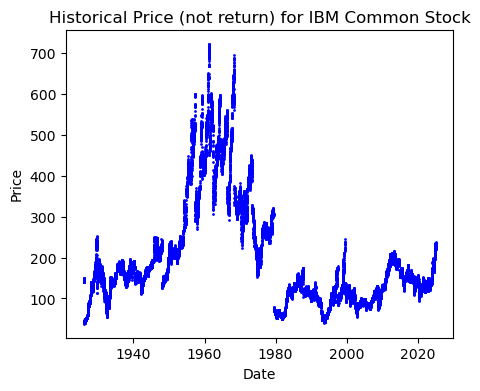

In [20]:
fig = plt.figure(figsize=(5,4))
price = dfx.loc[b_ibm, 'DlyPrc']
date = dfx.loc[b_ibm, 'DlyCalDt']
plt.scatter(date, price , color='b', s=1.00)
plt.title("Historical Price (not return) for IBM Common Stock")
plt.xlabel("Date")
plt.ylabel("Price")
# plt.yscale('log')


### IBM returns with dividends and stock splits

CRSP uses the column 'DlyRet' to describe the return from holding IBM stock for one day. The hypothetical experiment is to buy the stock at yesterday's closing price, collect any cash dividends or additional shares distributed as stock dividends (stock splits), then sell the stock at today's closing price. The return is the change in the value of the investment as a fraction of the amount invested. To implement this, CRSP must add dividends to the return and also add the value received from stock splits.  In addition, other corporate events may occasionally occur (spinoffs, mergers, etc.).

Let's see if we can replicate CRSP's calculation of 'DlyRet' by using the data on stock price, dividends, and stock splits.

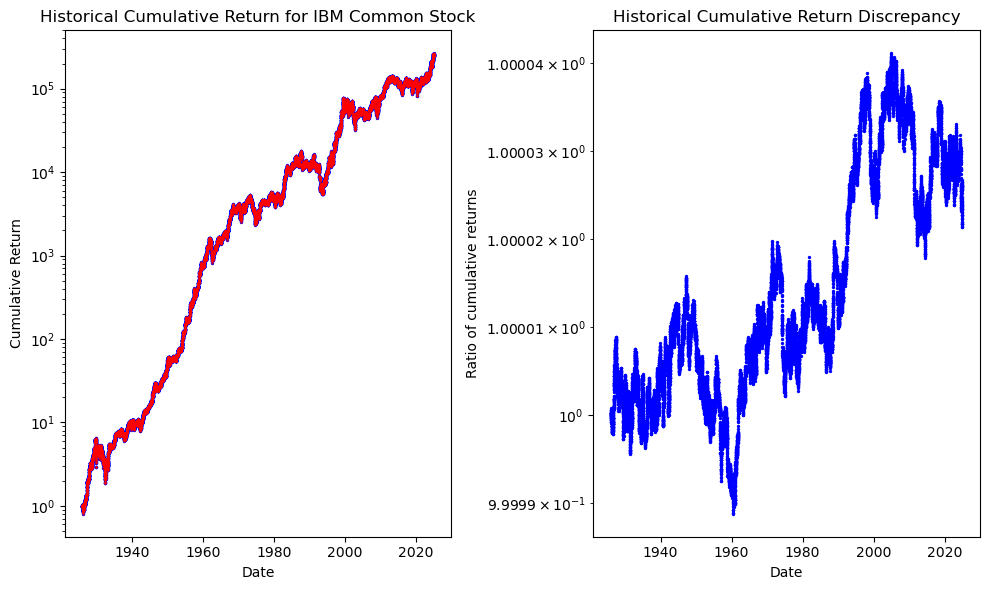

In [21]:
return_ibm = df_ibm['DlyRet'].fillna(0.0)
gross_return_ibm = 1.00 + return_ibm
cumulative_return_ibm = gross_return_ibm.cumprod()
df_ibm['cumulative_return'] = cumulative_return_ibm

gross_ret_ibm_replicated = ((df_ibm['DlyPrc'] * df_ibm['DlyFacPrc'] + df_ibm['DlyOrdDivAmt']) / df_ibm['DlyPrevPrc']).fillna(1.0)
cum_ret_ibm_replicated =  gross_ret_ibm_replicated.cumprod()

date = df_ibm['DlyCalDt']

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].scatter(date, cumulative_return_ibm , color='b', s=2.00)
ax[0].scatter(date, cum_ret_ibm_replicated , color='r', s=0.20)
ax[0].set_title("Historical Cumulative Return for IBM Common Stock")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Cumulative Return")
ax[0].set_yscale('log')

ax[1].scatter(date, cumulative_return_ibm / cum_ret_ibm_replicated , color='b', s=2.00)
ax[1].set_title("Historical Cumulative Return Discrepancy")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Ratio of cumulative returns")
ax[1].set_yscale('log')

plt.tight_layout()


As you can see, the replication worked well. Errors appear to be rounding error.  Perhaps we got lucky in that IBM did not have any of the occasional other corporate events which can affect returns.

### More on stock splits

Investors sometimes try to make a distinction between stock splits and stock dividends, even though these are conceptually the same concept.

Companies sometimes give investors extra shares proportional to their ownership of existing shares.  Since this creation of extra shares tends to have no effect on the total value of the company (**market capitalization**), the value of the shares should immediately fall by a proportional amount. We can think of a **stock dividend** as a relatively small number of shares given per 100 shares owned.  We can think of a **stock split** as a large number of shares given per 100 shares owned. The cutoff between a stock dividend and a stock split is purely arbitrary. Some investors use a 2 for 1 stock split as the cutoff (i.e., any stock dividend which gives more than 100 shares per 100 shares owned is considered to be a stock split.)

As we can see from the following cell, IBM has had both small stock dividends and large stock splits. For example, it has had 4 2-for-1 splits, 1 3-for-1 split, and 1 4_for-1 split, which alone should have reduced the price of the stock by a factor of $2^4 * 3 * 4 = 192$ over the years.

What does matter finacially with stock dividends is whether the company acquires the shares distributed to shareholders by creating new shares out of thin air (perfectly acceptable) or by buying back previously issued shares in the market.

In [22]:
dfx.loc[b_ibm, 'DlyFacPrc'].value_counts().reset_index(drop=False).sort_values('DlyFacPrc')

,DlyFacPrc,count
0,1.000000,26009
11,1.004233,1
6,1.020000,2
2,1.025000,6
10,1.027108,1
7,1.030000,2
13,1.043657,1
1,1.050000,18
3,1.250000,5
5,1.500000,3


In [23]:
dfx.loc[b_ibm, 'DlyOrdDivAmt'].value_counts().reset_index(drop=False).sort_values('DlyOrdDivAmt')

,DlyOrdDivAmt,count
0,0.000000,25655
38,0.120000,3
29,0.130000,4
18,0.140000,4
19,0.150000,4
23,0.160000,4
24,0.180000,4
12,0.200000,7
33,0.220000,4
48,0.240000,1


### Mean Returns

We can measure mean daily returns for IBM stock as follows:

(Note that a **basis point** is defined as one one-hundredth of one percent. Sticklers for financial terminology may argue about whether basis points should have time unites.  Here they do not.)

In [24]:
mean_return_ibm = df_ibm['DlyRet'].mean()
print(f"{mean_return_ibm=} = {mean_return_ibm * 10**4} basis points per trading day")

mean_return_ibm=0.0005925396166993125 = 5.925396166993125 basis points per trading day


### Internal rate of return

The **internal rate of return** (**IRR**) is the hypothetical constant rate of return which gives the same total return as actual random rate of return observed over a given time period.



In [25]:
num_trading_days_ibm = len(df_ibm)
cum_ret_ibm = df_ibm.loc[df_ibm.index[-1], 'cumulative_return'] / df_ibm.loc[df_ibm.index[0], 'cumulative_return']
irr_factor_ibm = (cum_ret_ibm)**(1 / (num_trading_days_ibm - 1))
irr_ibm = irr_factor_ibm - 1.00


print(f"{num_trading_days_ibm=}")
print(f"{cum_ret_ibm=}")
print(f"{irr_ibm=} = {irr_ibm * 10**4} basis points per trading day")


num_trading_days_ibm=26055
cum_ret_ibm=244793.86879240462
irr_ibm=0.00047636166951914305 = 4.7636166951914305 basis points per trading day


### Mean return and internal rate of return are different

Note that the mean return and the internal rate of return are different!

The internal rate of return is a **geometric mean**, which is different from an **arithmetic mean**.

This particular issue is a huge source of confusion in finance! We will discuss it more later.

### Standard deviation of returns

In finance, the standard deviation of returns is often called **volatility**.

Later in this course, we will later discuss a slightly different but closely related concept, **log-volatility**, often called **Black-Scholes volatility**.

Let's calculate the mean daily standard deviation of IBM returns over its lifetime:

In [26]:
std_ibm = df_ibm['DlyRet'].std()
print(f"{std_ibm=} = {std_ibm * 10**2} percent per day = {std_ibm * 10**4} basis points per day")

std_ibm=0.015216875965947145 = 1.5216875965947145 percent per day = 152.16875965947145 basis points per day


# Homework Questions

You should answer all of the homework questions below.  They are all straightforward, designed to familiarize you with typical usage of Pandas in finance.

If you are not familiar with Pandas, there will be a learning curve here.  I encourage you to:

1. Look carefully at my sample code above.  Almost every line illustrates usage for later in this course and typical usage for practitioners or researchers.

2. Read the Pandas and Numpy documentation to familiarize yourself with the available functions and their typical syntax.

3. Ask questions using google. **Stackoverflow** often give exactly the answer you are looking for.

If you find yourself running out of time and cannot finish all questions by the due date, try to do the last question.

### Question 1 (Easy)

1.  Which companies were already in existence when CRSP data starts in 1925-12-31?

4. Guess when CRSP started reporting ticker symbols.

5. Point out one additional interesting fact you observe. 

### Question 2 (Easy)

Why does Berkshire Hathaway have more rows of data than Intel (INTC), even though Intel has existed for a longer time?

### Question 3 (Easy)

When playing with datasets, it is useful to do mental "reality checks" along the way. Since the data start in 1925 and end in 2024, we might guess the number of rows in the dataset is very approximately

100 years * 250 trading days per year * 10 stocks = 250_000.

How many rows are actually in the dataset? Why is there a big difference between our guess and the actual answer? (This question has a very simple common-sense answer, which can be easily guessed based on common knowledge and  which can also be verified by looking at the data carefully.)



### Question 4 (Easy)

Why would an annually updated subscription to financial data (such as CRSP) be much cheaper than a subscription updated daily?

What timeframes for updates to financial data subscriptions are most valuable?

(Hint: Do not spend much time on this question. Just think about it for a few minutes and make a quick guess. We can discuss further in class.)

### Question 5

Study the documentation for `pd.read_csv(...)`.

Compare the time it takes to read a CSV file and convert object dtypes to datetime or pyarrow[string] with the time it takes to read a saved parquet file.

### Question 6

Create a table which describes in a nice way the exchange each company trades on ('N' for NYSE and 'Q' for Nasdaq)? Did any of the companies change their primary (listing) exchange?

When a company is delisted, how does this how up in the CRSP data?



### Question 7

Create a nice table showing the number of times each company has paid an ordinary (cash) dividend. Did any of the companies never pay an ordinary dividend?





### Question 8

If you bought 100 shares of stock for each company on the inital date it show up in the CRSP data and held the shares until the last day which shows up (e.g., 2024-12-31), how many shares would you own on the last day if you did not reinvest dividends into the company's stock but did keep extra shares received from stock dividend (stock splits)?

**Extra Credit**: How many shares of each company's stock would you own on the last day if you invested every dividend back into the company's stock on the day it was received and did not have to pay taxes on the dividends. (Hint: This might be a case where a slow, inefficient Python loop appears to be needed. Can you avoid the loop by using Pandas or Numpy functions?)



### Question 9

Create a nice table listing each security's PERMNO and PERMCO, the security's name on the last day,  the first and last dates, the value to which one dollar grows (if all dividends are reinvested back into the company), the dollar market capitalization of the company on the last day (in dollars), the daily volatility (in basis points), the daily mean return (in basis points), and the daily internal rate of return (in basis points).

Hint: Use `groupby(...).agg(...)`. In addition to 'mean', 'sum', and 'std', there are also some other useful aggregation functions (**reductions**), such as 'first' and 'last'.

### Question 10

Create 12 different plots on a 4 by 3 grid showing the cumulative return of one dollar invested in each company's stock.

Create on big plot showing the cumulative return on all of the securities (PERMNO) over time. (This plot will have different beginning and ending dates for varous companies.)

### Extra Credit

Play around with some of the other columns of the dataset. Be prepared to tell the class something interesting that you learn, either about CRSP data or about the companies themselves.


In [27]:
elapsed_time = timeit.default_timer() - t_begin
print(f"done: {elapsed_time=}")

done: elapsed_time=3.698420099914074
